In [5]:
# This is the test script for the final submission 
# No external library other than numpy is allowed 

# sys is only used to point to the correct folder
import sys
sys.path.insert(0, 'project1/scripts')

# import all the functions from the helper module 
from proj1_helpers import *
from implementations import *
from proj1_plot_helpers import * 
from proj1_feature_selection import *

In [6]:
# Import, fill in missing values with average, and perform data preprocessing 
y, inputs, ids = load_clean_csv("train.csv", False, missing_val="avg")

In [3]:
def stepwise_regression(inputs, y):
    queue = list(range(inputs.shape[1]))
    selected = []
    feats = []
    current_score, best_score = 10.0e8, 10.0e8
    while any(queue) and current_score == best_score:
        scores_candidates = []
        for candidate in queue:
            feats = selected + [candidate]
            poly_basis = build_poly(inputs[:, feats], 1)
            _, score = least_squares(y, poly_basis)
            scores_candidates.append((score, candidate))

        scores_candidates.sort(reverse = True)
        best_score, best_candidate = scores_candidates.pop()
        if current_score > best_score:
            queue.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_score
    feats = selected
    return feats

In [7]:
# Takes only the 10 best features
feature_list = stepwise_regression(inputs,y)[:10]
feature_list.sort()

In [8]:
feature_list

[1, 2, 4, 7, 10, 11, 12, 13, 16, 19]

In [ ]:
# # Obtain features by finding correlation coefficients
# coef_vec = pairwise_correlation(y, inputs)
# pairwise_correlation_plot(coef_vec)

# feature_threshold = 0.1 
# feature_list = feature_select(coef_vec, feature_threshold)
# corr_matrix = correlation_matrix(inputs, feature_list)
# # print("feature list before removing the duplicates", feature_list)
# # feature_correlation_plot(corr_matrix)


In [ ]:
# # remove from feature list features with correlation coef higher than threhold
# duplicate_threshold = 0.8

# feature_list = feature_extract(feature_list, corr_matrix, duplicate_threshold)
# corr_matrix = correlation_matrix(inputs, feature_list)
# # print("feature list after removing the duplicates", feature_list)
# # feature_correlation_plot(corr_matrix)

In [9]:
import itertools as it

def build_poly_plus(x, degree):
    """
    Builds polynomial basis function of a certain degree combining all features.
    """
    poly = np.ones((len(x), 1))

    for deg in range(1, degree+1):
        if deg == 1:
            poly = np.c_[poly, x]
        else:
            for i in it.combinations_with_replacement(range(x.shape[1]),deg):
                poly = np.c_[poly, np.prod(x[:,i],1)]
    return poly

In [10]:
x = inputs[:, feature_list]
degree = 3
k_fold = 4

tx = build_poly_plus(x, degree)
print(tx.shape)
lambdas = np.logspace(-5, 0, 30)

# some dummy values, just to make sure the functions are properly called 
gammas = np.logspace(-3, 0, 20)
init_w = np.zeros(tx.shape[1])
max_it = 10

opt_lambda, rmse_tr, rmse_te = find_desired_var(lambdas, y, tx, k_fold, ridge_regression)
print("ridge regression done. opt_lambda is", opt_lambda)
# opt_gamma_1, rmse_tr1, rmse_te1 = find_desired_var(gammas, y, tx, k_fold, logistic_regression, init_w, max_it)
# print("logistic regression done. opt_gamma is", opt_gamma_1)
# opt_gamma_2, rmse_tr2, rmse_te2 = find_desired_var(gammas, y, tx, k_fold, least_squares_GD, init_w, max_it)
# print("least squares GD done. opt_gamma is", opt_gamma_2)
# opt_gamma_3, rmse_tr3, rmse_te3 = find_desired_var(gammas, y, tx, k_fold, least_squares_SGD, init_w, max_it)
# print("least squares SGD done. opt_gamma is", opt_gamma_3)


(250000, 286)
ridge regression done. opt_lambda is 0.005736152510448681


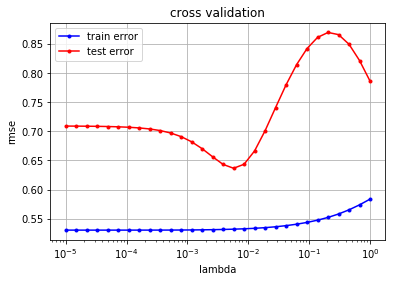

In [12]:
# print(opt_lambda)
cross_validation_plot(lambdas, rmse_tr, rmse_te)
# cross_validation_plot(gammas, rmse_tr1, rmse_te1)
# cross_validation_plot(gammas, rmse_tr2, rmse_te2)
# cross_validation_plot(gammas, rmse_tr3, rmse_te3)
#plt.savefig("Figures/fig_ridge_train_test_error.eps",format = "eps")

In [14]:
tx_train, y_train, tx_test, y_test = split_data(tx, y, 0.5)

# weights, mse = ridge_regression(y_train, tx_train, opt_lambda)

#zt Update find_weight parameters. Please see the following cases 
# weights, mse = find_weight(y, tx, k_indices, opt_lambda, k_fold, degree)

# dummy variables. Just to make sure the functions are properly called 
init_w = np.zeros(tx_train.shape[1])
max_it = 10
gamma = 0.1

# weights, mse = find_weight(y, tx, k_fold, least_squares)
# print("least squares done")
# w1, mse1 = find_weight(y, tx, k_fold, least_squares_GD, init_w, max_it, gamma)
# print("least squares GD done")
# w2, mse2 = find_weight(y, tx, k_fold, least_squares_SGD, init_w, max_it, gamma )
# print("least squares SGD done")
w3, mse3 = find_weight(y, tx, k_fold, ridge_regression, opt_lambda)
print("ridge regression done")
# w4, mse4 = find_weight(y, tx, k_fold, logistic_regression, init_w, max_it, gamma)
# print("logistic regression done")
# print(weights.shape)

y_pred = predict_labels(w3, tx_test)

compute_score(y_test, y_pred)

rmse_train = np.sqrt(2*compute_mse(y_train, tx_train, w3))
rmse_test = np.sqrt(2*compute_mse(y_test, tx_test, w3))
print("Train RMSE:", rmse_train, ", Test RMSE:", rmse_test)


# ignore: 
# Total correct: 25127.0 
# Total incorrect: 8930.0 
# Correct percentage: 73.77925242975012 %
# Train RMSE: 0.9343418873952883 , Test RMSE: 0.9337667902727746

# median: 
# Total correct: 95019.0 
# Total incorrect: 29981.0 
# Correct percentage: 76.01520000000001 %
# Train RMSE: 0.9228025288225072 , Test RMSE: 0.9226877174336481

# Average performs the best 

ridge regression done
Total correct: 100533.0 
Total incorrect: 24467.0 
Correct percentage: 80.4264 %
Train RMSE: 0.9018965667603247 , Test RMSE: 0.9019040631376253


In [15]:
y_test, inputs_test, ids_test = load_clean_csv('test.csv', False, "avg", True)

In [16]:
tx_test = build_poly_plus(inputs_test[:,feature_list], degree)
y_pred = predict_labels(weights, tx_test)

NameError: name 'weights' is not defined

In [ ]:
#create_csv_submission(ids_test, y_pred, "prediction.csv")